# Version 2 : VGG16

In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

2024-03-25 10:07:43.189289: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 10:07:43.358868: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 10:07:43.360348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 10:07:44.538502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image if necessary
    x = np.array(img) / 255.0
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    return img, x

1/1 [==============================] - 0s 472ms/step


/tmp/ipykernel_3534/3359815132.py:21: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()  # Ensure proper spacing between subplots


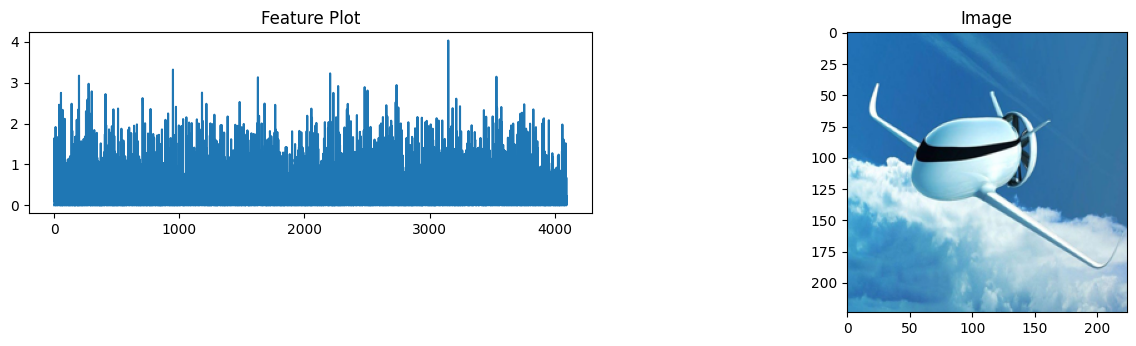

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_path = "./Dataset/download/Planes/4.jpeg"
img, x = load_image(image_path)
feat = feat_extractor.predict(x)

plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# Create the first subplot for the plot of feat[0]
plt.subplot(3, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(feat[0])
plt.title('Feature Plot')

# Create the second subplot for displaying the image
plt.subplot(2, 2, 2)  # 1 row, 2 columns, subplot 2
plt.imshow(img)
plt.title('Image')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


In [9]:
import ReadBuddy as rb
my_reader=rb.ReadBuddy("./Dataset/download/")
_,folder_dict=my_reader.create_folder_dictionary()


In [10]:
features = []
for i in folder_dict:
    
    for image_path in folder_dict[i]:

        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)


1/1 [==============================] - 0s 139ms/step


In [11]:
copy_features=features.copy()
copy_featuresfeatures = np.array(copy_features)

In [12]:

from sklearn.decomposition import PCA


pca = PCA(n_components=900)
pca.fit(copy_features)

PCA(n_components=900)

In [13]:
pca_features = pca.transform(copy_features)


In [14]:
images = [folder_dict[i] for i in folder_dict]
images = [item for sublist in images for item in sublist]


In [15]:
from scipy.spatial import distance



def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


1/1 [==============================] - 0s 295ms/step


Text(0.5, 1.0, 'Direct Vectorization results')

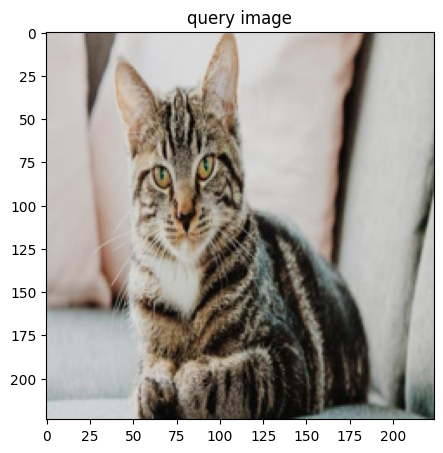

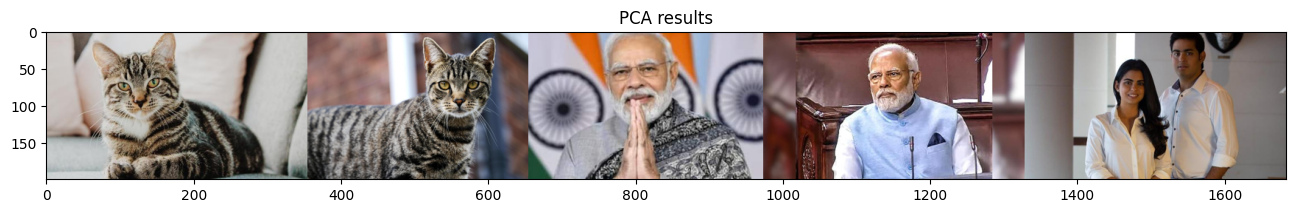

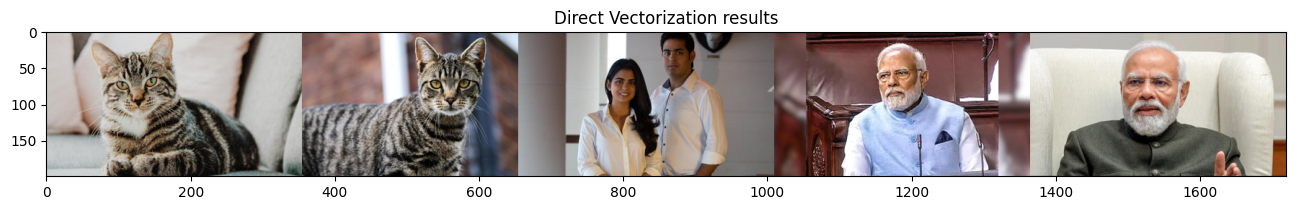

In [20]:

# load image and extract features
new_image, x = load_image("./Dataset/download/Cat/20.jpeg")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
pca_distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
n_distances = [ distance.cosine(new_features[0], feat) for feat in features ]

idx_closest = sorted(range(len(pca_distances)), key=lambda k: pca_distances[k])[0:5]  # grab first 5
n_idx_closest = sorted(range(len(n_distances)), key=lambda k: n_distances[k])[0:5]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)
n_results_image = get_concatenated_images(n_idx_closest, 200)

# display the results
plt.figure(figsize = (5,15))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,8))
plt.imshow(results_image)
plt.title("PCA results")

# display the resulting images
plt.figure(figsize = (16,8))
plt.imshow(n_results_image)
plt.title("Direct Vectorization results")